<a href="https://colab.research.google.com/github/malhartrivedi/FakeNewsDetection/blob/main/Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#google colab drive mount code

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
# reading data file
df = pd.read_csv('/content/drive/MyDrive/Data-NLP/WELFake_Dataset.csv')

In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
df.columns = ["id","title","text","label"]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      72134 non-null  int64 
 1   title   71576 non-null  object
 2   text    72095 non-null  object
 3   label   72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


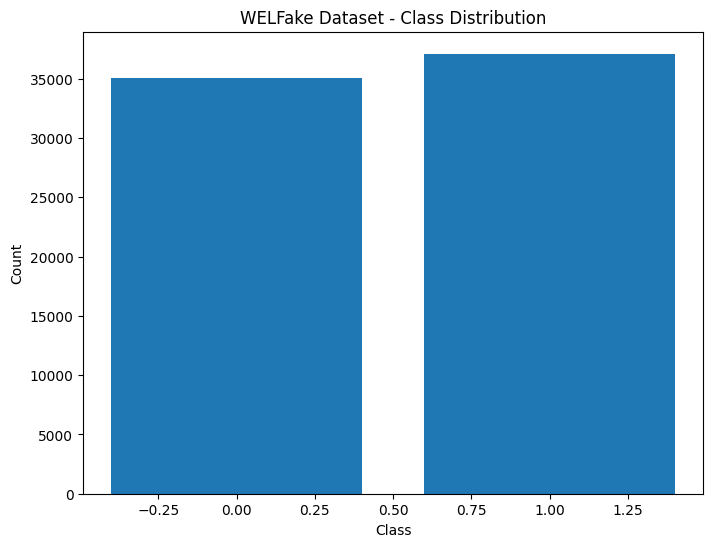

In [ ]:
# Count the number of samples in each class
class_counts = df['label'].value_counts()

# Create a bar chart to visualize the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('WELFake Dataset - Class Distribution')
plt.show()

In [ ]:
!pip install matplotlib wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preprocessing and feature extraction

In [ ]:
# read in our data and preprocess it

df.drop(labels=['id','title'], axis='columns', inplace=True)


In [ ]:
df['text']

0        No comment is expected from Barack Obama Membe...
1           Did they post their votes for Hillary already?
2         Now, most of the demonstrators gathered last ...
3        A dozen politically active pastors came here f...
4        The RS-28 Sarmat missile, dubbed Satan 2, will...
                               ...                        
72129    WASHINGTON (Reuters) - Hackers believed to be ...
72130    You know, because in fantasyland Republicans n...
72131    Migrants Refuse To Leave Train At Refugee Camp...
72132    MEXICO CITY (Reuters) - Donald Trump’s combati...
72133    Goldman Sachs Endorses Hillary Clinton For Pre...
Name: text, Length: 72134, dtype: object

In [ ]:
df.dropna(subset = ["text"], inplace=True)

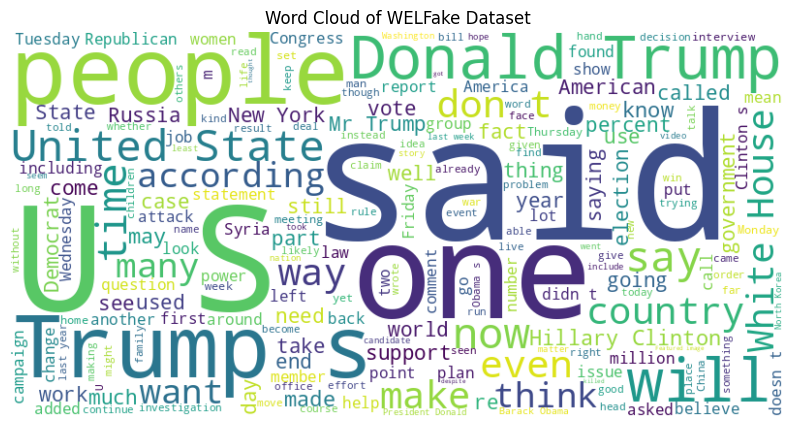

In [ ]:
from wordcloud import WordCloud

# Concatenate all the text from the dataset
all_text = ' '.join(df['text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of WELFake Dataset')
plt.show()


In [ ]:
# Removing stopwords

from gensim.parsing.preprocessing import remove_stopwords
def stopword_removal(row):
    text = row['text']
    text = remove_stopwords(text)
    return text

In [ ]:
df['text'] = df.apply(stopword_removal, axis=1)

In [ ]:
# Converting text into smaller letters.

df['text'] = df['text'].str.replace('[^\w\s]+', '').str.lower()


<ipython-input-15-d860723b1988>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]+', '').str.lower()


In [ ]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 72095 texts.


In [ ]:
texts = texts.fillna("")

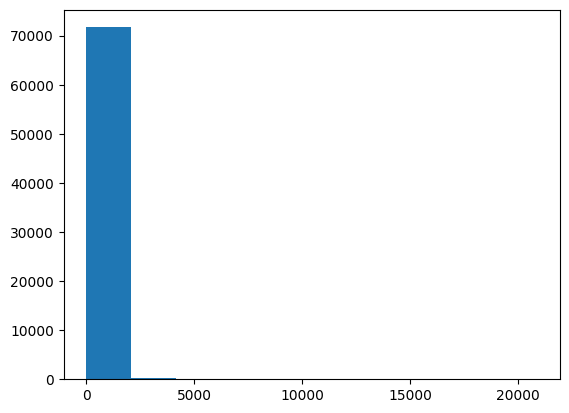

In [ ]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

In [ ]:
MAX_SEQUENCE_LENGTH = 700
MAX_NUM_WORDS = 1000
EMBEDDING_DIM = 64
TEST_SPLIT = 0.2

In [ ]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='post',
                     truncating='post')

# Reshape the data to have the shape (num_samples, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)
data = np.reshape(data, (data.shape[0], MAX_SEQUENCE_LENGTH, 1))


print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 380635 unique tokens.
Shape of data tensor: (72095, 700, 1)
Shape of label tensor: (72095,)


# Data Curation Phase

In [ ]:
# split the data into a training set and a validation set

from sklearn.model_selection import train_test_split



x, x_test, y, y_test = train_test_split(data,
                                        labels,
                                        test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x,
                                                  y,
                                                  test_size=0.1)

In [ ]:
x_train.shape

(51908, 700, 1)

In [ ]:
x_val.shape

(5768, 700, 1)

In [ ]:
x_test.shape

(14419, 700, 1)

# Model Building Phase

In [ ]:
from keras import layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.optimizers import RMSprop

# Defining dropout layers
dropout1 = 0.4
dropout2 = 0.5
num_classes = 1

model = Sequential([
    # Part 1: Word and sequence processing
    # Defining embedding layer where embedding dimension/vector size is defined as 64 and input length is set as MAX_SEQUENCE_LENGTH.
    layers.Embedding(num_words,
                     EMBEDDING_DIM,
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=True),
    # Convolutional layer with 64 filters and kernel size of 5.
    layers.Conv1D(64, 5, activation='relu'),
    # Max pooling layer with pool size of 2.
    layers.MaxPooling1D(2),
    # Dropout layer
    layers.Dropout(dropout1),

    # Convolutional layer with 32 filters and kernel size of 3.
    layers.Conv1D(32, 3, activation='relu'),
    # Max pooling layer with pool size of 2 and strides of 2.
    layers.MaxPooling1D(2, strides=2),

    # LSTM layer with 64 units.
    layers.LSTM(64, return_sequences=True),

    # Part 2: Classification
    # Flatten the output of the LSTM layer
    layers.Flatten(),

    # Dense layer with 256 neurons and ReLU activation.
    layers.Dense(256, activation='relu'),
    # Dropout layer
    layers.Dropout(dropout2),
    # Output layer with sigmoid activation for binary classification.
    layers.Dense(num_classes, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 700, 64)           64000     
                                                                 
 conv1d_3 (Conv1D)           (None, 696, 64)           20544     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 348, 64)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 348, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 346, 32)           6176      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 173, 32)          0         
 1D)                                                  

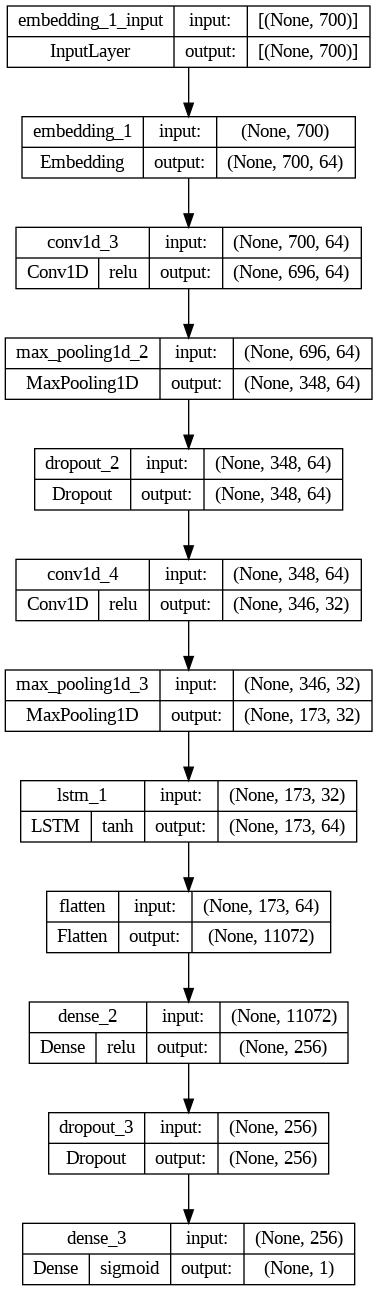

In [ ]:
# visalizing the layers of model.
import tensorflow as tf

tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

# Model Training Phase

In [ ]:
# train the model with batch size of 128 and 15 epochs.
import time as t
start = t.time()
history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_val, y_val))

print("total training time:",t.time()-start)

Epoch 1/15
406/406 [==============================] - 26s 29ms/step - loss: 0.1750 - accuracy: 0.9251 - val_loss: 0.0992 - val_accuracy: 0.9629
Epoch 2/15
406/406 [==============================] - 9s 22ms/step - loss: 0.0824 - accuracy: 0.9714 - val_loss: 0.0845 - val_accuracy: 0.9700
Epoch 3/15
406/406 [==============================] - 8s 21ms/step - loss: 0.0602 - accuracy: 0.9794 - val_loss: 0.0757 - val_accuracy: 0.9752
Epoch 4/15
406/406 [==============================] - 9s 22ms/step - loss: 0.0440 - accuracy: 0.9851 - val_loss: 0.0656 - val_accuracy: 0.9769
Epoch 5/15
406/406 [==============================] - 9s 23ms/step - loss: 0.0325 - accuracy: 0.9889 - val_loss: 0.0796 - val_accuracy: 0.9750
Epoch 6/15
406/406 [==============================] - 8s 20ms/step - loss: 0.0262 - accuracy: 0.9908 - val_loss: 0.0881 - val_accuracy: 0.9738
Epoch 7/15
406/406 [==============================] - 9s 22ms/step - loss: 0.0237 - accuracy: 0.9913 - val_loss: 0.0959 - val_accuracy: 0.973

In [ ]:
!pip install keras_flops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

In [ ]:
def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

In [ ]:
# calculating flops
flops = get_flops(model, batch_size = 128)
print(flops)
print(f"FLOPS: {flops / 10 ** 9:.03} G ")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


4207493120
FLOPS: 4.21 G 


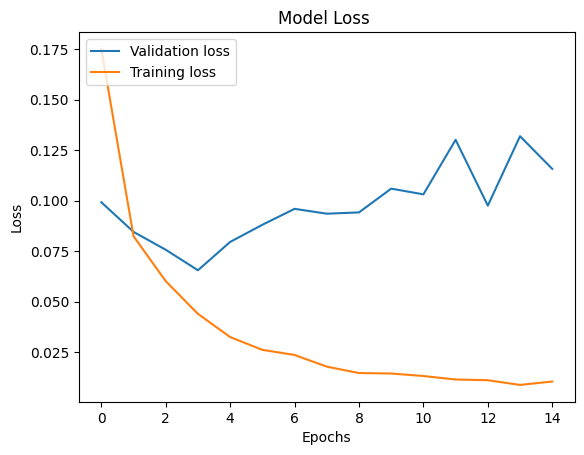

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss ')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Validation loss', 'Training loss'], loc='upper left')
plt.show()

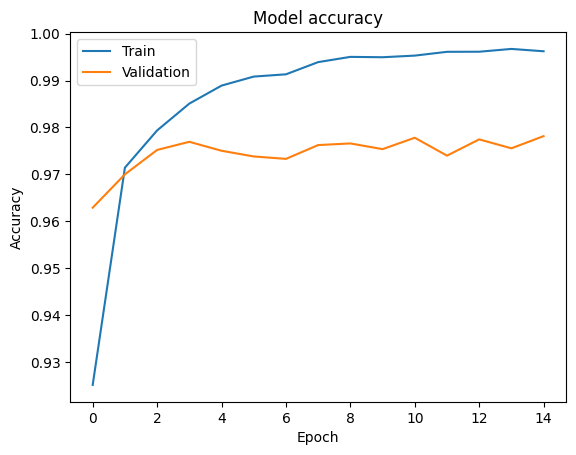

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing Phase

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
451/451 [==============================] - 3s 6ms/step - loss: 0.1074 - accuracy: 0.9805
test loss, test acc: [0.10740955919027328, 0.9805118441581726]


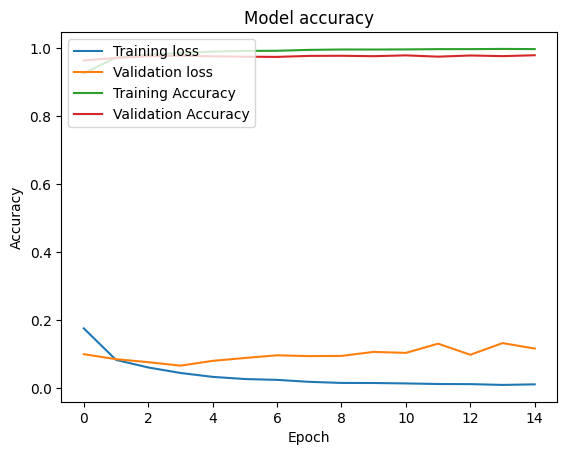

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss','Training Accuracy','Validation Accuracy'], loc='upper left')
plt.show()

# Evaluation Phase

In [ ]:
# define a function that allows us to evaluate models

from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,classification_report,roc_curve



def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing accuraries are reported
    '''
    # training acc
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)

    # testing acc
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)

    import time

    # Start timer
    start_time = time.time()
    y_predict_test = predict_fun(X_test)
    # End timer
    end_time = time.time()

    # Calculate inference time per sample
    inference_time = (end_time - start_time) / len(X_test)

    # Print inference time
    print("Per sample inference time =", inference_time)

    test_acc = accuracy_score(y_test, y_predict_test)

    # accuracy = accuracy_score(y_test,y_pred_tex)
    roc_auc =roc_auc_score(y_test, y_predict_test)
    precision = precision_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    recall = recall_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)

    cr = classification_report(y_test, y_predict_test,zero_division=1)


    fpr, tpr, threshold = roc_curve(y_test, y_predict_test)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label= 'CNN')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('%s ROC Curve'% 'CNN',fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

    roc_auc_sc = roc_auc_score(y_test,y_predict_test)

    return train_acc, test_acc,cr,roc_auc_sc

451/451 [==============================] - 3s 7ms/step


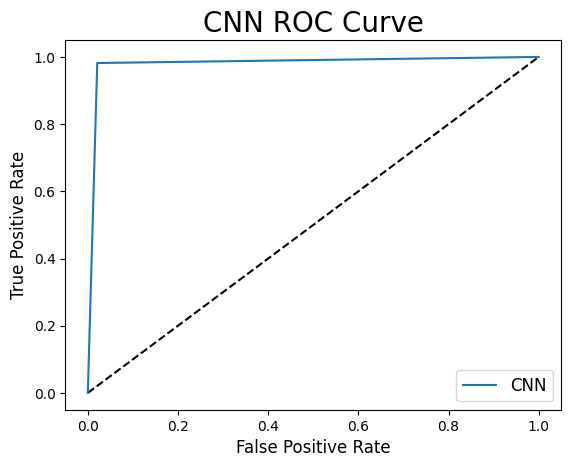

Training Accuracy: 99.96%
Testing Accuracy: 98.05%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      7086
           1       0.98      0.98      0.98      7333

    accuracy                           0.98     14419
   macro avg       0.98      0.98      0.98     14419
weighted avg       0.98      0.98      0.98     14419

AUC score 0.9804882786797445
Total time required for testing 26.04563283920288


In [ ]:
# evaluate model
import time as t
start = t.time()
train_acc, test_acc,cr,roc_auc_sc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train,
                                     y_train,
                                     x_test,
                                     y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Classification Report:\n",cr)
print("AUC score",roc_auc_sc)
print("Total time required for testing",t.time()-start)